In [259]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import kerastuner as kt
from tensorflow.keras.models import load_model

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix

In [20]:
import keras.backend as K

def f1_metric(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

Using TensorFlow backend.


In [109]:
def model_performance(history):
  #get results
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(acc)) # Get number of epochs

  fig, [ax1,ax2] = plt.subplots(2,1, sharex=True, gridspec_kw={'hspace':0.4})
  # Plot training and validation accuracy per epoch
  ax1.plot(epochs,acc,label='training')
  ax1.plot(epochs,val_acc,label='test')
  ax1.set_title('Training and validation accuracy')
  ax1.legend()

  # Plot training and validation loss per epoch
  ax2.plot(epochs,loss,label='training')
  ax2.plot(epochs,val_loss,label='test')
  ax2.legend()
  ax2.set_title('Training and validation loss')

In [110]:
def get_result(y, predict):
    print('f1_score: {}'.format(f1_score(y, predict,average='macro')))
    print('\nconfucsion matrix: \n{}'.format(confusion_matrix(y,predict)))
    print('\nclassification report: \n{}'.format(classification_report(y, predict)))

# Import data and pipeline

In [243]:
X = pd.read_csv('../datasets/X_oversample.csv')

In [244]:
y = pd.read_csv('../datasets/y_oversample.csv')

In [8]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8288 entries, 0 to 8287
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   county_name                7740 non-null   object 
 1   idcard_cnt                 8288 non-null   int64  
 2   sms_per_receiver           8285 non-null   float64
 3   sms_calltype_1             8285 non-null   float64
 4   sms_calltype_2             8285 non-null   float64
 5   call_dur                   8123 non-null   float64
 6   voc_opposite_no_m          8123 non-null   float64
 7   voc_calltype_1             8123 non-null   float64
 8   voc_calltype_2             8123 non-null   float64
 9   voc_calltype_3             8123 non-null   float64
 10  voc_receive_unique_county  8123 non-null   float64
 11  data_with_known_app_no     8288 non-null   float64
 12  data_with_known_app_yes    8288 non-null   float64
 13  network_usage              8288 non-null   float

In [14]:
final_num_pipe = Pipeline([('num_impute',SimpleImputer(strategy='median')),
                           ('num_scale',MinMaxScaler())])
final_cat_pipe = Pipeline([('impute',SimpleImputer(strategy='most_frequent')),
                           ('ohe',OneHotEncoder(handle_unknown='ignore'))])
final_preprocess_pipe = ColumnTransformer([('numeric',final_num_pipe,make_column_selector(dtype_exclude='object')),
                                    ('county_name',final_cat_pipe,make_column_selector(dtype_include='object'))])

In [131]:
train_x, test_x, train_y, test_y = train_test_split(X, y, random_state=0, test_size=0.2)
train_x_transformed = final_preprocess_pipe.fit_transform(train_x).todense()
train_y = train_y.values.reshape(-1,1)
test_x_transformed = final_preprocess_pipe.transform(test_x).todense()
test_y = test_y.values.reshape(-1,1)

In [132]:
train_x_transformed.shape

(6630, 195)

# Neural Network

## Baseline score

In [186]:
model = keras.Sequential()
model.add(layers.Dense(50,input_shape=(195,)))
model.add(layers.Dense(50,activation='relu'))
model.add(layers.Dense(50,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))
model.compile(optimizer=Adam(lr=0.001),loss='binary_crossentropy',metrics=['accuracy', f1_metric])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 50)                9800      
_________________________________________________________________
dense_5 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 51        
Total params: 14,951
Trainable params: 14,951
Non-trainable params: 0
_________________________________________________________________


In [137]:
early_stop = EarlyStopping(monitor='val_f1_metric', mode='max', verbose=1, patience=10,
              restore_best_weights=True)

In [138]:
EPOCHS = 100
BATCH = 64

In [139]:
model_history = model.fit(train_x_transformed, train_y, epochs=EPOCHS, 
                          validation_split=0.2,
                          callbacks=[early_stop], verbose=0)

Restoring model weights from the end of the best epoch.
Epoch 00081: early stopping


highest f1 score: 0.9038106799125671


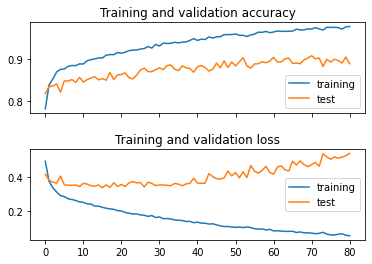

In [140]:
print('highest f1 score: {}'.format(np.max(model_history.history['val_f1_metric'])))
model_performance(model_history)

In [141]:
predictions = model.predict(test_x_transformed)
predictions = np.where(predictions>0.5,1,0)
get_result(test_y, predictions)

f1_score: 0.9016286272655566

confucsion matrix: 
[[768  87]
 [ 76 727]]

classification report: 
              precision    recall  f1-score   support

           0       0.91      0.90      0.90       855
           1       0.89      0.91      0.90       803

    accuracy                           0.90      1658
   macro avg       0.90      0.90      0.90      1658
weighted avg       0.90      0.90      0.90      1658



We get very promissing results, let's see if we can do better

## Hyperparameter tunning

In [192]:
def model_builder(hp):
    model = keras.Sequential()
    model.add(layers.Dense(2000, input_shape=(195,)))
    for i in range(hp.Int('num_layers', 2, 5)):
        model.add(layers.Dense(2000, activation='relu'))
    model.add(layers.Dense(1,activation='sigmoid'))
    model.compile(optimizer=Adam(lr=0.001),loss='binary_crossentropy',metrics=['accuracy', f1_metric])
    return model

In [194]:
tuner = kt.Hyperband(model_builder, objective=kt.Objective("val_f1_metric", direction="max"), 
                     seed=0, max_epochs=10, project_name='NN_search')

In [197]:
# early_stop = EarlyStopping(monitor='val_f1_metric', mode='max', verbose=0, patience=10,
#               restore_best_weights=True)
# tuner.search(train_x_transformed, train_y, epochs=EPOCHS, 
#                           validation_split=0.2,
#                           callbacks=[early_stop], verbose=2)

In [196]:
tuner.results_summary(1)

### Testing

### Focus on val loss

Even though I suspect focusing on val loss will result in good results, but let's try

In [204]:
UNITS = 2000
model = keras.Sequential()
model.add(layers.Dense(UNITS,input_shape=(195,)))
model.add(layers.Dense(UNITS,activation='relu'))
model.add(layers.Dense(UNITS,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))
model.compile(optimizer=Adam(lr=0.001),loss='binary_crossentropy',metrics=['accuracy', f1_metric])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 2000)              392000    
_________________________________________________________________
dense_12 (Dense)             (None, 2000)              4002000   
_________________________________________________________________
dense_13 (Dense)             (None, 2000)              4002000   
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 2001      
Total params: 8,398,001
Trainable params: 8,398,001
Non-trainable params: 0
_________________________________________________________________


In [205]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10,
              restore_best_weights=True)

In [206]:
EPOCHS = 100
BATCH = 64

In [207]:
model_history = model.fit(train_x_transformed, train_y, epochs=EPOCHS, 
                          validation_split=0.2,
                          callbacks=[early_stop], verbose=0)

Restoring model weights from the end of the best epoch.
Epoch 00020: early stopping


highest f1 score: 0.8751996159553528


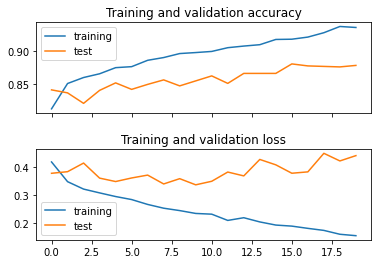

In [208]:
print('highest f1 score: {}'.format(np.max(model_history.history['val_f1_metric'])))
model_performance(model_history)

In [209]:
predictions = model.predict(test_x_transformed)
predictions = np.where(predictions>0.5,1,0)
get_result(test_y, predictions)

f1_score: 0.8787997520438836

confucsion matrix: 
[[786  69]
 [131 672]]

classification report: 
              precision    recall  f1-score   support

           0       0.86      0.92      0.89       855
           1       0.91      0.84      0.87       803

    accuracy                           0.88      1658
   macro avg       0.88      0.88      0.88      1658
weighted avg       0.88      0.88      0.88      1658



Let's just go back to focusing on f1 score

### Focus on f1 metrics

In [210]:
UNITS = 2000
model = keras.Sequential()
model.add(layers.Dense(UNITS,input_shape=(195,)))
model.add(layers.Dense(UNITS,activation='relu'))
model.add(layers.Dense(UNITS,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))
model.compile(optimizer=Adam(lr=0.001),loss='binary_crossentropy',metrics=['accuracy', f1_metric])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 2000)              392000    
_________________________________________________________________
dense_16 (Dense)             (None, 2000)              4002000   
_________________________________________________________________
dense_17 (Dense)             (None, 2000)              4002000   
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 2001      
Total params: 8,398,001
Trainable params: 8,398,001
Non-trainable params: 0
_________________________________________________________________


In [211]:
early_stop = EarlyStopping(monitor='val_f1_metric', mode='max', verbose=1, patience=10,
              restore_best_weights=True)

In [212]:
EPOCHS = 100

In [213]:
model_history = model.fit(train_x_transformed, train_y, epochs=EPOCHS, 
                          validation_split=0.2,
                          callbacks=[early_stop], verbose=0)

Restoring model weights from the end of the best epoch.
Epoch 00066: early stopping


highest f1 score: 0.9068281054496765


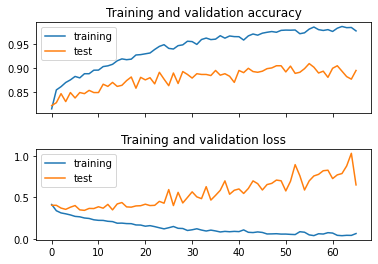

In [214]:
print('highest f1 score: {}'.format(np.max(model_history.history['val_f1_metric'])))
model_performance(model_history)

In [215]:
predictions = model.predict(test_x_transformed)
predictions = np.where(predictions>0.5,1,0)
get_result(test_y, predictions)

f1_score: 0.908322747465576

confucsion matrix: 
[[751 104]
 [ 48 755]]

classification report: 
              precision    recall  f1-score   support

           0       0.94      0.88      0.91       855
           1       0.88      0.94      0.91       803

    accuracy                           0.91      1658
   macro avg       0.91      0.91      0.91      1658
weighted avg       0.91      0.91      0.91      1658



## Training the best model

In [245]:
X_transformed = final_preprocess_pipe.fit_transform(X).todense()
y = y.values

In [246]:
UNITS = 2000
model = keras.Sequential()
model.add(layers.Dense(UNITS,input_shape=(195,)))
model.add(layers.Dense(UNITS,activation='relu'))
model.add(layers.Dense(UNITS,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))
model.compile(optimizer=Adam(lr=0.001),loss='binary_crossentropy',metrics=['accuracy', f1_metric])
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_35 (Dense)             (None, 2000)              392000    
_________________________________________________________________
dense_36 (Dense)             (None, 2000)              4002000   
_________________________________________________________________
dense_37 (Dense)             (None, 2000)              4002000   
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 2001      
Total params: 8,398,001
Trainable params: 8,398,001
Non-trainable params: 0
_________________________________________________________________


In [247]:
early_stop = EarlyStopping(monitor='val_f1_metric', mode='max', verbose=1, patience=10,
              restore_best_weights=True)

checkpoint = ModelCheckpoint('NN_saved_model/{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_f1_metric', 
                             mode='max', save_best_only=True, verbose=1)

In [248]:
EPOCHS = 100

In [249]:
model_history = model.fit(X_transformed, y, epochs=EPOCHS, 
                          validation_split=0.2,
                          callbacks=[early_stop, checkpoint], verbose=0)


Epoch 00001: val_f1_metric improved from -inf to 0.82865, saving model to NN_saved_model/01-0.36.hdf5

Epoch 00002: val_f1_metric improved from 0.82865 to 0.84383, saving model to NN_saved_model/02-0.32.hdf5

Epoch 00003: val_f1_metric did not improve from 0.84383

Epoch 00004: val_f1_metric improved from 0.84383 to 0.84951, saving model to NN_saved_model/04-0.34.hdf5

Epoch 00005: val_f1_metric improved from 0.84951 to 0.85692, saving model to NN_saved_model/05-0.31.hdf5

Epoch 00006: val_f1_metric did not improve from 0.85692

Epoch 00007: val_f1_metric did not improve from 0.85692

Epoch 00008: val_f1_metric improved from 0.85692 to 0.86110, saving model to NN_saved_model/08-0.30.hdf5

Epoch 00009: val_f1_metric did not improve from 0.86110

Epoch 00010: val_f1_metric improved from 0.86110 to 0.88290, saving model to NN_saved_model/10-0.30.hdf5

Epoch 00011: val_f1_metric did not improve from 0.88290

Epoch 00012: val_f1_metric did not improve from 0.88290

Epoch 00013: val_f1_metr

highest f1 score: 0.9088925123214722


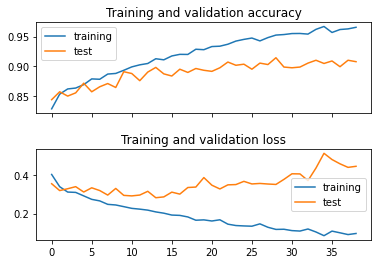

In [250]:
print('highest f1 score: {}'.format(np.max(model_history.history['val_f1_metric'])))
model_performance(model_history)

In [ ]:
model.save('NN_model.hdf5')

In [252]:
#let's try if we should continue training
model_history2 = model.fit(X_transformed, y, epochs=EPOCHS, 
                          validation_split=0.2,
                          callbacks=[early_stop, checkpoint], verbose=0)


Epoch 00001: val_f1_metric did not improve from 0.90889

Epoch 00002: val_f1_metric did not improve from 0.90889

Epoch 00003: val_f1_metric did not improve from 0.90889

Epoch 00004: val_f1_metric did not improve from 0.90889

Epoch 00005: val_f1_metric improved from 0.90889 to 0.91078, saving model to NN_saved_model/05-0.44.hdf5

Epoch 00006: val_f1_metric did not improve from 0.91078

Epoch 00007: val_f1_metric did not improve from 0.91078

Epoch 00008: val_f1_metric did not improve from 0.91078

Epoch 00009: val_f1_metric did not improve from 0.91078

Epoch 00010: val_f1_metric did not improve from 0.91078

Epoch 00011: val_f1_metric improved from 0.91078 to 0.91242, saving model to NN_saved_model/11-0.46.hdf5

Epoch 00012: val_f1_metric did not improve from 0.91242

Epoch 00013: val_f1_metric did not improve from 0.91242

Epoch 00014: val_f1_metric did not improve from 0.91242

Epoch 00015: val_f1_metric improved from 0.91242 to 0.91729, saving model to NN_saved_model/15-0.65.hdf

highest f1 score: 0.9210894107818604


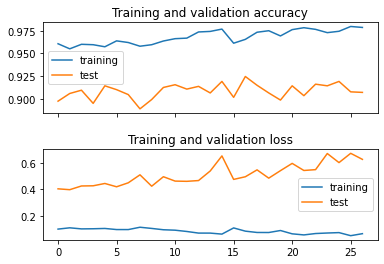

In [255]:
print('highest f1 score: {}'.format(np.max(model_history2.history['val_f1_metric'])))
model_performance(model_history2)

In [254]:
model.save('NN_model2.hdf5')

In [256]:
#let's try if we should continue training, again
model_history3 = model.fit(X_transformed, y, epochs=EPOCHS, 
                          validation_split=0.2,
                          callbacks=[early_stop, checkpoint], verbose=0)


Epoch 00001: val_f1_metric did not improve from 0.92109

Epoch 00002: val_f1_metric did not improve from 0.92109

Epoch 00003: val_f1_metric did not improve from 0.92109

Epoch 00004: val_f1_metric did not improve from 0.92109

Epoch 00005: val_f1_metric did not improve from 0.92109

Epoch 00006: val_f1_metric did not improve from 0.92109

Epoch 00007: val_f1_metric did not improve from 0.92109

Epoch 00008: val_f1_metric did not improve from 0.92109

Epoch 00009: val_f1_metric did not improve from 0.92109

Epoch 00010: val_f1_metric did not improve from 0.92109

Epoch 00011: val_f1_metric improved from 0.92109 to 0.92301, saving model to NN_saved_model/11-0.59.hdf5

Epoch 00012: val_f1_metric did not improve from 0.92301

Epoch 00013: val_f1_metric did not improve from 0.92301

Epoch 00014: val_f1_metric did not improve from 0.92301

Epoch 00015: val_f1_metric did not improve from 0.92301

Epoch 00016: val_f1_metric did not improve from 0.92301

Epoch 00017: val_f1_metric improved fr

highest f1 score: 0.9274663925170898


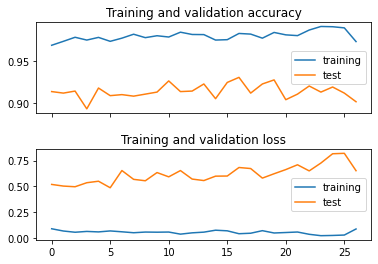

In [257]:
print('highest f1 score: {}'.format(np.max(model_history3.history['val_f1_metric'])))
model_performance(model_history3)

In [258]:
model.save('NN_model3.hdf5')

The improvement in f1 score is very small at this stage

# Prediction

In [301]:
submission_x = pd.read_csv('../datasets/submission_rename.csv')

In [265]:
submission_x_transformed = final_preprocess_pipe.transform(submission_x)

In [318]:
best_model = load_model('NN_model2.hdf5', custom_objects={"f1_metric": f1_metric})

In [319]:
prediction = best_model.predict(submission_x_transformed)

In [320]:
prediction_output = np.where(prediction>0.5, 1, 0).reshape(-1,)

In [321]:
index = pd.read_csv('../datasets/submission_v1.csv')['phone_no_m'].values

In [322]:
submission = pd.DataFrame([index, prediction_output]).T
submission.columns = ['phone_no_m','label']

In [323]:
submission

,phone_no_m,label
0,22d522340df77e2252c1a4d92b4bcb00d515e36f3ec6bf...,0
1,5220d4b8429bdba3971a7b46a088c6b8fa6710f4060759...,1
2,7d19dd2b50ced56f03d23bf928cf34dc570a48525571a8...,0
3,134a4a591185c9d3788021896dcfc235e9e0a6a1e3f8a4...,1
4,2356dcd6759d50455ddaeed03c838843558e9182d5962f...,0
...,...,...
2040,b544be7faeb565e3b25b2624121b6fbb188dd783304054...,0
2041,8f8220d7b20f8a7d92a443c97f2276b4d62f7d058cb172...,0
2042,2390f521ad86b31fa73e8e6395817a8c447ce077796c79...,0
2043,15a2d650f7a7a24b3e8dfdd5e59dc251cb3043f290fcaf...,0


In [324]:
submission.to_csv('../datasets/submission_v3.csv', index=False)